In [1]:
import sys
import os
import time
import codecs
import pandas as pd

sys.path.append("/Users/Bya/git/predictEPL/utils/")
sys.path.append("/Users/Bya/git/predictEPL/config/")

import emolex
import paths
import tokenizer
import useful_methods as my_methods
import train_datas

In [7]:
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

Populating the interactive namespace from numpy and matplotlib


### Step 0. Read Data

In [8]:
# Read Data
dfTwitter = train_datas.TweetPnEqualRead()

# Change sentiment to number
label_dic = {
    'positive': 1,
    'negative': 0,
}

dfTwitter.sentiment = [label_dic[sentiment] for sentiment in list(dfTwitter.sentiment)]
dfTwitter.head()

,sentiment,tweet
0,0,If they play New Born tomorrow instead of SS I...
1,1,"C'mon, of course they would ... - Conor McGreg..."
2,0,MARKET WATCH: NYMEX crude oil prices slipped g...
3,0,The International Committee of the Red Cross o...
4,0,@McMwiti Really? really? Terry's guilt was wel...


### Step 1: Load Data, look around

In [9]:
# POS vs NEG
dfTwitter.groupby('sentiment').describe()

tweet
sentiment                                                          
0         count                                                1834
          unique                                               1834
          top     How are you spending your Saturday night? I'm ...
          freq                                                    1
1         count                                                1834
          unique                                               1834
          top     @TheRealPodVader need more ESPN football today...
          freq                                                    1

In [10]:
# Adding 'length' column
dfTwitter['length'] = [len(text) for text in dfTwitter['tweet']]
dfTwitter.head()

,sentiment,tweet,length
0,0,If they play New Born tomorrow instead of SS I...,136
1,1,"C'mon, of course they would ... - Conor McGreg...",134
2,0,MARKET WATCH: NYMEX crude oil prices slipped g...,91
3,0,The International Committee of the Red Cross o...,138
4,0,@McMwiti Really? really? Terry's guilt was wel...,141


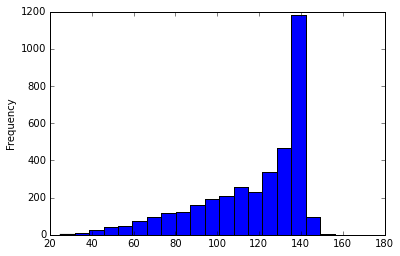

In [11]:
dfTwitter.length.plot(bins=20, kind='hist')

In [12]:
dfTwitter.length.describe()

count    3668.000000
mean      117.148310
std        25.450484
min        25.000000
25%       101.000000
50%       127.000000
75%       138.000000
max       163.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a8551d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10a9240f0>], dtype=object)

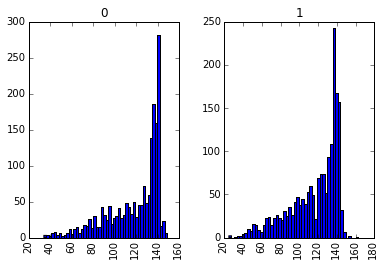

In [13]:
# Tweet Length: POS vs NEG 
dfTwitter.hist(column='length', by='sentiment', bins=50)

### Step 2: Data Preprocessing

In [15]:
dfTwitter.tweet.head()

0    If they play New Born tomorrow instead of SS I...
1    C'mon, of course they would ... - Conor McGreg...
2    MARKET WATCH: NYMEX crude oil prices slipped g...
3    The International Committee of the Red Cross o...
4    @McMwiti Really? really? Terry's guilt was wel...
Name: tweet, dtype: object

In [17]:
# Applying Stemming
dfTwitter.tweet.head().apply(tokenizer.Stem)

0    [play, new, born, tomorrow, instead, ss, throw...
1    [c'mon, cours, would, conor, mcgregor, say, 'd...
2    [market, watch, nymex, crude, oil, price, slip...
3    [intern, committe, red, cross, friday, warn, t...
4    [mcmwiti, realli, realli, terri, 's, guilt, we...
Name: tweet, dtype: object

In [18]:
# Applying Lemmatizing
dfTwitter.tweet.head().apply(tokenizer.Lemma)

0    [play, new, born, tomorrow, instead, throw, on...
1    [c'mon, course, would, conor, mcgregor, say, '...
2    [market, watch, nymex, crude, oil, price, slip...
3    [international, committee, red, cross, friday,...
4    [mcmwiti, really, really, terry, 's, guilt, we...
Name: tweet, dtype: object

### Step 3: Data to Vectors

In [20]:
%time bow_transformer = CountVectorizer(analyzer=tokenizer.Stem).fit(dfTwitter['tweet'])
# unique words
print(len(bow_transformer.vocabulary_))

CPU times: user 3.54 s, sys: 18.2 ms, total: 3.56 s
Wall time: 3.63 s
9792


In [21]:
# Let's take one text message and get its bag-of-words counts as a vector,
# putting to use our new bow_transformer:

tweet1 = dfTwitter['tweet'][1]
print(tweet1)

C'mon, of course they would ... - Conor McGregor says he'd beat Floyd Mayweather -- and Ronda Rousey would too http://t.co/4P7llh2qse



In [22]:
bow1 = bow_transformer.transform([tweet1])
print(bow1)
print(bow1.shape)

  (0, 13)	1
  (0, 1195)	1
  (0, 1668)	1
  (0, 2207)	1
  (0, 2295)	1
  (0, 3470)	1
  (0, 5572)	1
  (0, 5590)	1
  (0, 7446)	1
  (0, 7478)	1
  (0, 7646)	1
  (0, 9605)	2
(1, 9792)


In [25]:
print(bow_transformer.get_feature_names()[2295])
print(bow_transformer.get_feature_names()[7478])

cours
rousey


In [26]:
# The bag-of-words counts for the entire Tweets corpus are a large,
# sparse matrix:

tweets_bow = bow_transformer.transform(dfTwitter['tweet'])
print('sparse matrix shape:', tweets_bow.shape)
print('number of non-zeros:', tweets_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * tweets_bow.nnz / (tweets_bow.shape[0] * tweets_bow.shape[1])))

sparse matrix shape: (3668, 9792)
number of non-zeros: 45530
sparsity: 0.13%


In [27]:
# And finally, after the counting,
# the term weighting and normalization can be done with TF-IDF,
# using scikit-learn's TfidfTransformer:

tfidf_transformer = TfidfTransformer().fit(tweets_bow)
tfidf1 = tfidf_transformer.transform(bow1)
print(tfidf1)

  (0, 9605)	0.392664356286
  (0, 7646)	0.190102565567
  (0, 7478)	0.313838766874
  (0, 7446)	0.334937989516
  (0, 5590)	0.241231924442
  (0, 5572)	0.351685384696
  (0, 3470)	0.334937989516
  (0, 2295)	0.289560733174
  (0, 2207)	0.23983164937
  (0, 1668)	0.235894942576
  (0, 1195)	0.232301010851
  (0, 13)	0.232301010851


In [28]:
# What is the IDF (inverse document frequency) of the
# word: "fun"? Of word: "go"?

print(tfidf_transformer.idf_[bow_transformer.vocabulary_['goal']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['shit']])

6.31730266646
5.40101193458


In [29]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

tweets_tfidf = tfidf_transformer.transform(tweets_bow)
print(tweets_tfidf.shape)

(3668, 9792)


### Step 4: Training a model and, classifying sentiment

In [30]:
%time sentiment_detector = MultinomialNB().fit(tweets_tfidf, dfTwitter['sentiment'])

CPU times: user 3.36 ms, sys: 785 µs, total: 4.15 ms
Wall time: 3.49 ms


In [31]:
# Let's try classifying our single random review:

print(dfTwitter.tweet[1], "\n")
print('predicted:', sentiment_detector.predict(tfidf1)[0])
print('expected:', dfTwitter.sentiment[1])

C'mon, of course they would ... - Conor McGregor says he'd beat Floyd Mayweather -- and Ronda Rousey would too http://t.co/4P7llh2qse
 

predicted: 1
expected: 1


In [32]:
# How many messages do we classify correctly overall?

all_predictions = sentiment_detector.predict(tweets_tfidf)
print(all_predictions)

[0 1 0 ..., 1 1 0]


In [33]:
print('accuracy', accuracy_score(dfTwitter['sentiment'], all_predictions))
print('confusion matrix\n', confusion_matrix(dfTwitter['sentiment'], all_predictions))
print('(row=expected, col=predicted)')

accuracy 0.947110141767
confusion matrix
 [[1722  112]
 [  82 1752]]
(row=expected, col=predicted)


/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


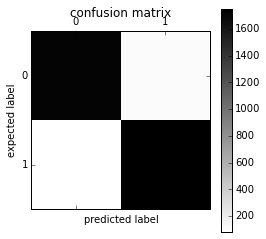

In [34]:
plt.matshow(confusion_matrix(dfTwitter['sentiment'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [35]:
# From this confusion matrix, we can compute:
# precision and recall, or their combination (harmonic mean) F1:

print(classification_report(dfTwitter['sentiment'], all_predictions))

             precision    recall  f1-score   support

          0       0.95      0.94      0.95      1834
          1       0.94      0.96      0.95      1834

avg / total       0.95      0.95      0.95      3668



### Step 5: How to run expirements?

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

In [36]:
tweets_train, tweets_test, sentiment_train, sentiment_test = \
    train_test_split(dfTwitter['tweet'], dfTwitter['sentiment'], test_size=0.2)

print(len(tweets_train), len(tweets_test), len(sentiment_train) + len(sentiment_test))


2934 734 3668


In [37]:
# Let's recap the entire pipeline up to this point,
# putting the steps explicitly into scikit-learn's Pipeline:

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=tokenizer.Stem)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

In [38]:
# In our case, everything goes smoothly though:

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         tweets_train,  # training data
                         sentiment_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.75510204  0.76190476  0.7585034   0.7755102   0.79522184  0.78156997
  0.76791809  0.7337884   0.78498294  0.73720137]


In [39]:
print(scores.mean(), scores.std())

0.765170300202 0.0189805560702


Naive Bayes is an example of a high bias - low variance classifier (aka simple and stable, not prone to overfitting). An example from the opposite side of the spectrum would be Nearest Neighbour (kNN) classifiers, or Decision Trees, with their low bias but high variance (easy to overfit). Bagging (Random Forests) as a way to lower variance, by training many (high-variance) models and averaging.

In other words:

* **high bias** = classifer is opinionated. Not as much room to change its mind with data, it has its own ideas. On the other hand, not as much room it can fool itself into overfitting either (picture on the left).
* **low bias** = classifier more obedient, but also more neurotic. Will do exactly what you ask it to do, which, as everybody knows, can be a real nuisance (picture on the right).

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 346 ms, sys: 63.6 ms, total: 410 ms
Wall time: 39.2 s


<module 'matplotlib.pyplot' from '/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/pyplot.py'>

/Users/Bya/.virtualenvs/py3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


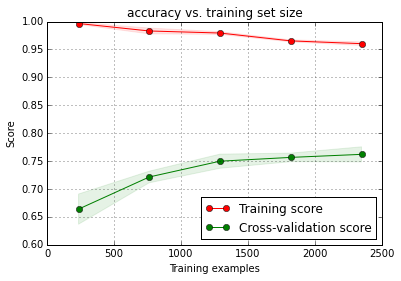

In [41]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", tweets_train, sentiment_train, cv=5)

### Step 6: How to tune Parameters?

What we've seen so far is only a tip of the iceberg: there are many other parameters to tune. One example is what algorithm to use for training.

We've used Naive Bayes above, but scikit-learn supports many classifiers out of the box: Support Vector Machines, Nearest Neighbours, Decision Trees, Ensamble methods...

[We can ask]: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [42]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (tokenizer.Stem, tokenizer.Lemma),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(sentiment_train, n_folds=5),  # what type of cross validation to use
)

In [43]:
%time nb_detector = grid.fit(tweets_train, sentiment_train)
print(nb_detector.grid_scores_)

CPU times: user 2.96 s, sys: 66.4 ms, total: 3.02 s
Wall time: 28.3 s
[mean: 0.76210, std: 0.01351, params: {'bow__analyzer': <function Stem at 0x106d3dc80>, 'tfidf__use_idf': True}, mean: 0.77641, std: 0.01558, params: {'bow__analyzer': <function Stem at 0x106d3dc80>, 'tfidf__use_idf': False}, mean: 0.76108, std: 0.01031, params: {'bow__analyzer': <function Lemma at 0x106d24f28>, 'tfidf__use_idf': True}, mean: 0.76653, std: 0.01271, params: {'bow__analyzer': <function Lemma at 0x106d24f28>, 'tfidf__use_idf': False}]


In [44]:
nb_detector.best_score_

0.776414451261077

In [45]:
nb_detector.best_params_

{'bow__analyzer': <function tokenizer.Stem>, 'tfidf__use_idf': False}

In [46]:
nb_detector.best_estimator_

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function Stem at 0x106d3dc80>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
       ...        use_idf=False)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [ ]:
# A quick sanity check:
%time print(nb_detector.predict_proba(["did not wonderful"])[0])
%time print(nb_detector.predict_proba(["Hi mom, how are you?"])[0])
%time print(nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

In [ ]:
# And overall scores on the test set,
# the one we haven't used at all during training:

predictions = nb_detector.predict(tweets_test)
print(confusion_matrix(sentiment_test, predictions))
print(classification_report(sentiment_test, predictions))

This is then the realistic predictive performance we can expect from our spam detection pipeline, when using lowercase with lemmatization, TF-IDF and Naive Bayes for classifier.

### Step 7: Productionalizing a predictor

With basic analysis and tuning done, the real work (engineering) begins.

The final step for a production predictor would be training it on the entire dataset again, to make full use of all the data available. We'd use the best parameters found via cross validation above, of course. This is very similar to what we did in the beginning, but this time having insight into its behaviour and stability. Evaluation was done honestly, on distinct train/test subset splits.

The final predictor can be serialized to disk, so that the next time we want to use it, we can skip all training and use the trained model directly:

In [ ]:
os.chdir("/Users/Bya/Dropbox/Research/datas/Detecter/")
# store the spam detector to disk after training
with open('nb_tweets_sentiment_detector(hash_emolex).pkl', 'wb') as fout:
    pickle.dump(nb_detector, fout)

In [ ]:
# Read Detecter
with open('nb_tweets_sentiment_detector(hash_emolex).pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'utf-8'
    nb_detector_reloaded = u.load()
    print(nb_detector_reloaded)

In [ ]:
tweet1

In [ ]:
%time print('before:', nb_detector.predict([tweet1])[0])
%time print ('after:', nb_detector_reloaded.predict([tweet1])[0])

In [ ]:
tweet = """
#Flamino!! Haha this is brilliant! Good work for his 1st goal. Cool as ice, walk in the park! #LFC #YNWA
"""

np_score = nb_detector.predict_proba([tweet])[0]
np = nb_detector.predict([tweet])[0]

print(np_score)
print(np)